# yelp2Vec 

Using the yelp dataset + word2vec

## 1.  Setup 

Before you can run this notebook, you need to install the necessary requirements. You should run 

$ pip install -r requirements.txt

in your terminal. 

Also make sure you have downloaded the yelp dataset, especially the "tips" file

In [246]:
# you'll probably get a lot of warnings here -- sorry 
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import json
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import hdbscan
% matplotlib inline
output_notebook()

Loading BokehJS ...

## 2. Preprocessing Data + Learning the Model

The yelp dataset gives us a json of users and their reviews for various restuarants and businesses. We want to preprocess this in to an adjanceny list form so that we can generate random walks over the graph, and throw it in to our word2vec model to generate "distributed" (vector) representations of the businesses. 

Our graph has nodes which are businesses. Edges are weighted connections between businesses, based off the number of users that reviewed both businesses. A pair of businesses which have never been reviewed by the same user have weight 0.

The script "prepreprocess.py" takes in this json + outputs an adjacency list form of our desired grpah

In [185]:
!python preprocess.py yelp_academic_dataset_tip.json

Constructing map - reviewer: business
Constructing map - business: business, weight
Writing to file


Now that we have an adjacency list form of the graph, we generate multiple random walks over the graphs and write them to text files, which will serve as the input to our word2vec model, to generate vector representations of the businesses. 

In [294]:
!python documentize.py yelp_academic_dataset_tip.txt tip2vec.txt

PROCESSING GRAPH
WRITING TO FILE


Now that we have the file, with each random walk seperated by a line (thus representing a document), we can just throw it in to gensim's python wrapper for word2vec. Ah, the joys of not having to work in C. 

In [189]:
model = Word2Vec(LineSentence('tip2vec.txt'), size=100, window=5, min_count=5, workers=4)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 42638 word types from a corpus of 997536 raw words and 10000 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:min_count=5 retains 25356 unique words (59% of original 42638, drops 17282)
INFO:gensim.models.word2vec:min_count=5 leaves 961577 word corpus (96% of original 997536, drops 35959)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 42638 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 4 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 959390 word corpus (99.8% of prior 961577)
INFO:gensim.models.word2vec:estimated required memory for 25356 words and 100 dimensions: 32962800 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.word2vec:training model with 4 workers o

We extract the ids of each business and their vector representations from our model for future use, and assert that we maintained order: 

In [198]:
business_ids, business_vecs = list(model.vocab.keys()), [model[bid] for bid in list(model.vocab.keys())]

# unit test to make sure that everythings in the right order
for idx in range(len(business_ids)):
    for array_idx, val in enumerate(model[business_ids[idx]]): 
        assert model[business_ids[idx]][array_idx] == business_vecs[idx][array_idx]

## 3.  Generating a DataFrame of Useful Restaurant Information

We read in the data from the yelp dataset and store useful information about restaurants that might be good metrics of comparison in the dataframe

In [199]:
# info we want to store in the dataframe
ids = []
latitude = []
longitude = []
categories = []
name = []
stars = []

# keys that we need to extract from the json to store in the
# info we care about 
keys = ['stars','latitude', 'longitude', 'categories', 'name']

with open('yelp_academic_dataset_business.json', 'r') as f: 
    for line in f: 
        # load each json -> each line is a json_dict
        business_data = json.loads(line)
        
        # extract business id and make sure that it's 
        # one we have a vector representation of 
        # (random walk may have skipped some businesses, etc.)
        bid = business_data["business_id"] 
        if bid in business_ids:
            # check to make sure json file contains all data because sometimes it doesn't
            # and we don't care if there's no info 
            if all([key in business_data for key in keys]): 
                ids.append(bid)
                name.append(business_data['name'])
                stars.append(business_data['stars'])
                latitude.append(business_data['latitude'])
                longitude.append(business_data['longitude'])
                categories.append(business_data['categories'])

# make that daggum dataframe             
df = pd.DataFrame(list(zip(ids, name, stars, latitude, longitude, categories)), 
                    columns = ['business_id', 'name', 'stars', 'lat', 'lng', 'categories'])

We also want to add the vector representations of businesses to the dataframe for reference:

In [200]:
df['vector'] = [model[bid] for bid in df['business_id']]

We do a sanity check to make sure our dataframe looks good: 

In [201]:
df.head()

,business_id,name,stars,lat,lng,categories,vector
0,1_lU0-eSWJCRvNGk78Zh9Q,Carnegie Free Library,4.5,40.406842,-80.085866,"[Libraries, Public Services & Government]","[-0.0963103, 0.0679244, 0.0314857, -0.167554, ..."
1,_qopVQ6_Mz6W7-Pmbi56GQ,Advance Auto Parts,3.5,40.398353,-80.082452,"[Automotive, Auto Parts & Supplies]","[-0.064731, 0.0568864, 0.0229814, -0.12861, 0...."
2,Cdcus0NADzyY3XiJM2O5Sg,Heidelberg B P,3.0,40.388284,-80.089241,"[Automotive, Gas & Service Stations]","[-0.195775, 0.154632, 0.0737828, -0.306864, 0...."
3,SQ0j7bgSTazkVQlF5AnqyQ,Don Don Chinese Restaurant,2.5,40.408347,-80.084962,"[Chinese, Restaurants]","[-0.0714054, 0.0329472, 0.0254406, -0.180049, ..."
4,wqu7ILomIOPSduRwoWp4AQ,Denny's,3.5,40.391140,-80.073788,"[Breakfast & Brunch, American (Traditional), D...","[-0.0988708, 0.0549295, 0.0224838, -0.193019, ..."


# 4. Manual Validation of Model 

We now want to see if our vector representations offer any meaningful metric of similarity. We can "visually" validate our vector represenations by looking at what businesses are considered "similar" to each other. 

In [209]:
def find_similar(bid, model, dataframe): 
    '''
        find_similar
        
        params: 
            bid: a string identifier of the business for 
            which you want to find similar businesses
                optional: can also be a list of bids
            
            model: a word2vec model that maps 
            business_ids to corresponding vectors
            
            dataframe: a dataframe containing (at least)
            'business_id' and corresponding 'vector'
            columns
        
        returns: a pandas dataframe of the top 10 similar 
                 businesses to the given bid. Note
                 that these are not in sorted order 
                 (for now)
    '''
    # extract top 10 most similar vector represenations from model
    similar_businesses = [t[0] for t in model.most_similar(bid)]
    # parse through df to find those most similar businesses 
    new_df = df[df['business_id'].isin(similar_businesses)]
    # return df of similar businesses 
    return new_df 

Now we test! '\_qopVQ6_Mz6W7-Pmbi56GQ\' is the string identifier for "Advanced Auto Parts." Let's see what's most similar to that

In [213]:
new_df = find_similar('_qopVQ6_Mz6W7-Pmbi56GQ', model, df)
new_df.head(10)

,business_id,name,stars,lat,lng,categories,vector
102,c1ixeRdwTvNt6YLew-sSCg,Parkway Center Mall,1.0,40.422462,-80.035601,"[Shopping Centers, Shopping]","[-0.124618, 0.0962142, 0.0535299, -0.244144, 0..."
150,z4cguIVh7jL9tTPf5EqRcA,David L. Lawrence Convention Center,3.5,40.445813,-79.996222,"[Event Planning & Services, Venues & Event Spa...","[-0.279789, 0.231827, 0.114922, -0.520659, 0.1..."
7358,pMm91uJMxfq6CFON9LqLRg,Bistro 19,4.0,40.380112,-80.044515,"[American (New), Restaurants]","[-0.180363, 0.137177, 0.0743509, -0.304754, 0...."
9348,AJVRAkLUB7ps0ARYWk6QtQ,Joseph-Beth Booksellers,4.5,40.424880,-79.980960,"[Books, Mags, Music & Video, Shopping]","[-0.117586, 0.0873632, 0.0591709, -0.222432, 0..."
9724,wlS-0nxpHQaFqv_iZ01fvw,Oh Yeah! Ice Cream & Coffee,3.5,40.457865,-79.925480,"[Food, Ice Cream & Frozen Yogurt, Coffee & Tea]","[-0.175929, 0.136421, 0.0751082, -0.309864, 0...."
10488,iwkDUiXpKjtSWWNyO9ORyg,Space,4.0,40.442682,-79.998308,"[Arts & Entertainment, Art Galleries, Shopping]","[-0.0865986, 0.0629779, 0.0313787, -0.13973, 0..."
12782,9hF1vOOkT-OMVhYwPCxtcw,JT's Restaurant,4.0,40.365187,-79.982437,"[Diners, Restaurants]","[-0.0910363, 0.0780005, 0.0415349, -0.177964, ..."
14179,_wmXYLUf4VThpcO9pDxHGg,Beer Nutz Bottle Shop,3.5,40.489980,-79.873971,"[Bars, American (Traditional), Nightlife, Rest...","[-0.14057, 0.126322, 0.0659112, -0.245177, 0.0..."
17764,cUVoyuhqv3ArYwwG_YcY1w,Crazy Mocha Coffee,3.5,40.455708,-80.006516,"[Food, Coffee & Tea]","[-0.137997, 0.105442, 0.0560443, -0.23143, 0.0..."
21161,JrdoWznKY-OFmwCkv75P_A,Nicky's Thai Kitchen,4.0,40.443941,-79.998232,"[Thai, Seafood, Vegan, Restaurants]","[-0.20393, 0.175143, 0.0979391, -0.364918, 0.1..."


It seems as if similar businesses have very similar latitude and longitude coordinates, but not much else. Let's test again on a restaurant. We'll use the identifier 'pMm91uJMxfq6CFON9LqLRg' for Bistro 19, an American restaurant

In [214]:
new_df = find_similar('pMm91uJMxfq6CFON9LqLRg', model, df)
new_df.head(10)

,business_id,name,stars,lat,lng,categories,vector
200,9SPwF-vRgtuHxciFxv5YLA,Soba,4.0,40.457103,-79.929635,"[Korean, Asian Fusion, Japanese, Restaurants]","[-0.18669, 0.151133, 0.0782453, -0.316213, 0.0..."
3614,Ii7h87LYLxug62Y_CmnXkA,North Shore Riverfront Park,4.5,40.445709,-80.007311,"[Active Life, Parks]","[-0.179346, 0.151455, 0.0698435, -0.2942, 0.09..."
3617,fvhWfSPlx5J_3F-ScLpvXQ,Penn Brewery,3.5,40.457127,-79.991547,"[German, Breweries, Venues & Event Spaces, Foo...","[-0.20545, 0.163067, 0.100372, -0.331996, 0.09..."
6326,J2x_AMx591i6TK3xccEzqQ,The Enrico Biscotti,4.0,40.451316,-79.983203,"[Bakeries, Food, Restaurants, Italian]","[-0.249007, 0.199813, 0.103947, -0.420936, 0.1..."
13208,fGTrdnKyM_wdT6niaxzU3Q,Hough's,4.0,40.426262,-79.940331,"[Bars, American (New), Restaurants, Sports Bar...","[-0.289807, 0.245938, 0.135388, -0.464578, 0.1..."
14179,_wmXYLUf4VThpcO9pDxHGg,Beer Nutz Bottle Shop,3.5,40.489980,-79.873971,"[Bars, American (Traditional), Nightlife, Rest...","[-0.14057, 0.126322, 0.0659112, -0.245177, 0.0..."
14226,qE5Q3Yj2Up3wewsh1NsTuA,Eggs-R-Us,4.0,40.427165,-80.055701,"[Breakfast & Brunch, Restaurants]","[-0.158666, 0.132155, 0.07251, -0.285929, 0.07..."
17288,CnKQgNyBmIvTE7zfegmV7Q,Savoy,3.5,40.455525,-79.978064,"[Wine Bars, Bars, American (New), Nightlife, R...","[-0.250737, 0.210851, 0.105074, -0.433313, 0.1..."
17445,v3MGJBF1Mc61KwgqiIY-uA,Park Bruges,4.0,40.476177,-79.920524,"[Belgian, Restaurants]","[-0.188209, 0.154296, 0.0887561, -0.330914, 0...."
25215,FJ8M_nW2hbh2JnJxEnZnjw,Bakersfield Penn Ave,4.5,40.443944,-79.996581,"[Bars, Mexican, Nightlife, Restaurants]","[-0.164152, 0.132853, 0.067053, -0.278174, 0.0..."


## 5. Statistical and Visual Validation of Model 

Out intuition, both from the design of this project and from the previous experiments, is that cosine-similar restaurants under our word2vec model will be located very close to each other in real space (latitude + longitude) along with vector space, as users that tip a lot of the same restaurants are often in closeby locations. We will test this by clustering over the vector representations of the restaurants, and then plotting our clusters against the latitude and longitude 

We'll start with an interactive scatter plot of latitude and longitude to see what we should initialize our clusters to

### Scatter Plot of Latitude and Longitude 

We offer a scatter plot of our latitude and longitude to see what distinct clusters (cities) we have, and to get an idea of what our geographic data looks like 

In [218]:
sns.lmplot?

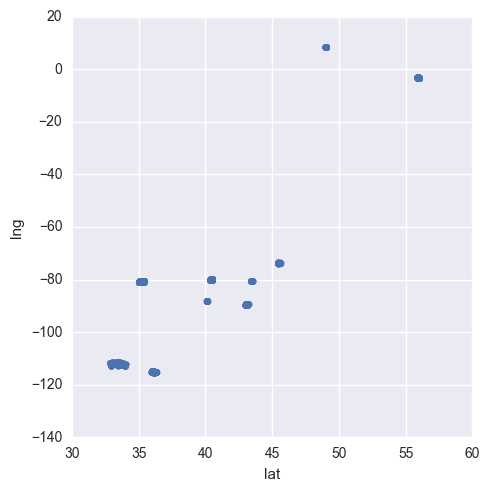

In [219]:
sns.lmplot(x = 'lat', y = 'lng', data = df, fit_reg= False)
sns.despine()

Before we do anything else, let's also try to visualize our restaurant vectors in two dimmensions. Right now they're 100 dimmensional vectors (incredibly hard to visualize) -- but let's try to see what they look like in two dimmensions. We use PCA to reduce the dimmensionality of the vectors and see what they look like

In [227]:
pca = PCA(2)
x = pca.fit_transform(list(df.vector))
df['2D_x'] = [c[0] for c in x]
df['2D_y'] = [c[1] for c in x]

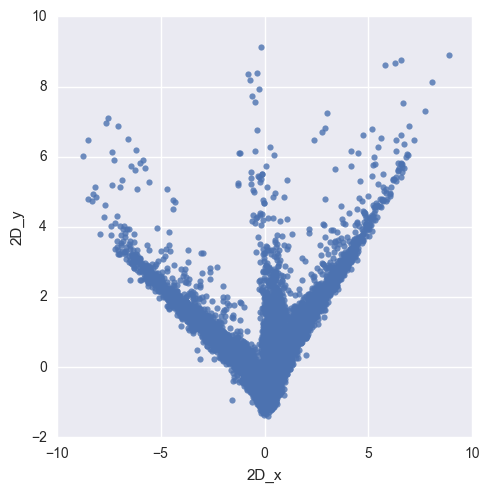

In [228]:
sns.lmplot(x = '2D_x', y = '2D_y', data = df, fit_reg = False)

I'm not sure what to make of that at all -- perhaps PCA is just fucked lol

In [281]:
vector_df = [[x[i] for x in list(df.vector)] for i in range(len(df.vector[0]))]

In [282]:
df['vector'][:5]

0    [-0.0963103, 0.0679244, 0.0314857, -0.167554, ...
1    [-0.064731, 0.0568864, 0.0229814, -0.12861, 0....
2    [-0.195775, 0.154632, 0.0737828, -0.306864, 0....
3    [-0.0714054, 0.0329472, 0.0254406, -0.180049, ...
4    [-0.0988708, 0.0549295, 0.0224838, -0.193019, ...
Name: vector, dtype: object

In [284]:
vector_df = pd.DataFrame(vector_df).T
vector_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.096310,0.067924,0.031486,-0.167554,0.055831,-0.001578,0.066797,0.000164,-0.073512,0.014476,...,0.035888,0.026123,0.202629,0.058460,-0.040654,-0.001042,0.102455,0.226367,0.113333,-0.175255
1,-0.064731,0.056886,0.022981,-0.128610,0.039030,-0.001042,0.056466,-0.000796,-0.044993,-0.000035,...,0.018551,0.013898,0.149843,0.037827,-0.033362,-0.005988,0.073221,0.182959,0.094053,-0.139199
2,-0.195775,0.154632,0.073783,-0.306864,0.099703,-0.004767,0.114388,0.032246,-0.136854,0.004546,...,0.082018,0.025979,0.352154,0.108105,-0.051937,-0.022647,0.178084,0.434593,0.171569,-0.337492
3,-0.071405,0.032947,0.025441,-0.180049,0.050664,-0.003912,0.052526,-0.025135,-0.024634,0.059347,...,-0.006050,0.044832,0.190554,0.019657,-0.029337,0.014822,0.054260,0.135221,0.095127,-0.123696
4,-0.098871,0.054930,0.022484,-0.193019,0.059736,0.000085,0.046692,-0.005391,-0.073025,0.039333,...,0.022124,0.044290,0.218989,0.049972,-0.030020,0.011802,0.084207,0.193918,0.089685,-0.173869


In [285]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
cluster_labels = clusterer.fit_predict(vector_df)

In [288]:
print(type(cluster_labels))
print(cluster_labels[:5])

<class 'numpy.ndarray'>
[939  -1 523 956  -1]


In [289]:
df['clusters'] = cluster_labels

In [293]:
# -1 is noisy clusters in hbdscan

In [291]:
clean_df = df[df['clusters'] != -1]

In [1]:
p = Scatter(clean_df, x='lat', y='lng', color='clusters', title="chart",
            xlabel="lat", ylabel="lng")
show(p)

NameError: name 'Scatter' is not defined